# Prerequisites

- Python 3.10.4

> Warning: Installation from conda environment may take few minutes

Configuring conda environment

```cmd
conda activate ca2_env
conda install pandas
conda install scikit-learn
```



In [1]:
from preamble import agriculture
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mglearn
from sklearn import linear_model
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')
sns.set_theme();


# Change default colormap
plt.rcParams["image.cmap"] = "Set2"
sns.set_palette("Set2")
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [2]:
# Datasets
agriculture_df = pd.read_csv("../data/agriculture_dataset.csv")

## Precition of the Gross Value Added for Ireland using CAP key meassurements

X : gross_value_added

# Dimensionality Reduction

### Feature Selection 1: Inferential analysis

Selection #1. Variables that has similar means and variances as detailed during inferential statistics analysis. They are as follows:

ANOVA: Variables and countries similar to Ireland.
```
0	BG	total_subsides_on_field_crops	0.7246195898894956	(BG) Bulgaria
1	SK	prod_cereals_real_price	0.9998980911821606	(SK) Slovakia
```

Kruskal–Wallis
Non parametrical test comparison indicates similar values with Ireland and selected  
Members states ['PT', 'BE', 'DK', 'IE', 'LV', 'LT', 'BG', 'SK'] on the following variables
```
variable	kruskal_test_result
2	compensation_of_employees	0.290062
6	total_subsides_on_field_crops	0.134577
7	rent_paid	0.778948
8	avg_import_idx	0.782263
9	avg_export_idx	0.617945
11	wages_and_salaries	0.720029
14	female_mean_weekly_working_hours	0.134016
16	pct_rented_land_of_uaa	0.064568
17	crop_production_idx	0.416883
```

In [3]:
countries = ['PT', 'BE', 'DK', 'IE', 'LV', 'LT', 'BG', 'SK']
independant_variables_1 = [
    'total_subsides_on_field_crops',
    'prod_cereals_real_price',
    'compensation_of_employees',
    'total_subsides_on_field_crops',
    'rent_paid',
    'avg_import_idx',
    'avg_export_idx',
    'wages_and_salaries',
    'female_mean_weekly_working_hours',
    'pct_rented_land_of_uaa',
    'crop_production_idx',
]

dependant_variable = ["gross_value_added"]
country_var = ["country"]
data = agriculture_df.query("country in @countries")[country_var + independant_variables_1 + dependant_variable]

### Feature Selection 1: Person Correlation
Select variable with positive or negative correlation greater than abs(0.5)

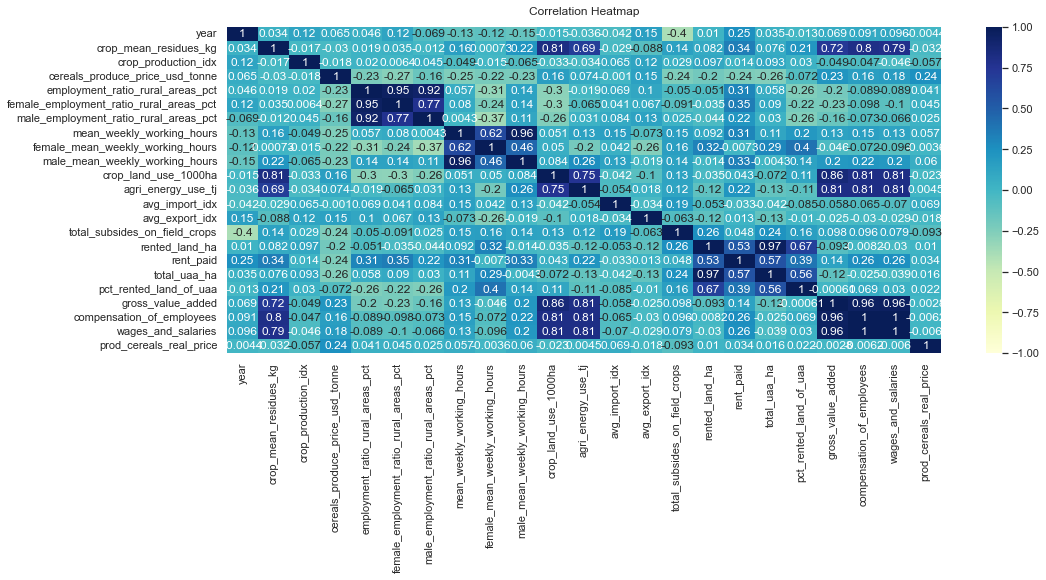

In [4]:
data = agriculture_df
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data.corr(method='pearson'), vmin=-1, vmax=1, annot=True,  cmap="YlGnBu")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [5]:
gva_corr = data.corr(method='pearson').reset_index().query("index == 'gross_value_added'").melt(id_vars=["index"])

In [6]:
gva_corr.query("value > 0.5 or value < -0.5")[["variable","value"]]

,variable,value
1,crop_mean_residues_kg,0.724757
10,crop_land_use_1000ha,0.861387
11,agri_energy_use_tj,0.806896
19,gross_value_added,1.000000
20,compensation_of_employees,0.960475
21,wages_and_salaries,0.963715


In [7]:
independant_variables_2 = [
    'crop_mean_residues_kg',
    'crop_land_use_1000ha',
    'agri_energy_use_tj',
    'compensation_of_employees',
    'wages_and_salaries'
]

Feature Selection 3: Principal Component Analysis


> PCA is a useful tool to extract features and reduce dataset dimensionality. Consequentially, it helps to
speed up the learning process and to simplify the presentation of the features. Before extracting some features,
it is very important to evaluate the impact of such an operation. In some cases, features can be extracted
without losing too much precision in the data. Although, in some other cases, significant resolution of the data
will be lost


Dessureault, J.-S. and Massicotte, D. (2021) ‘Feature selection or extraction decision process for clustering using PCA and FRSD’. Available at: https://search.ebscohost.com/login.aspx?direct=true&db=edsarx&AN=edsarx.2111.10492&site=eds-live.

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
# Full dataset or only countries relevant to Ireland??
independant_variables_all = []
for x in list(data.dtypes[data.dtypes == np.float64].index):
    if(x == dependant_variable[0]): 
        continue
    independant_variables_all.append(x)
X = data[independant_variables_all]
y = data[dependant_variable[0]]

In [10]:
# Split the data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
# Create and initialise an object (sc) by calling a method named as StandardScaler()
sc = StandardScaler()

# Train the model by calling a method fit_transform()
X_train = sc.fit_transform(X_train)

# Transform the data into standised form
X_test = sc.transform(X_test)

In [12]:
# Create and initialise an object (pca) by calling a method PCA
model = PCA(n_components = 7) # check for 2 or 3

# Transform the data into traning and testing
X_train = model.fit_transform(X_train)
X_test = model.transform(X_test)
 
# Store the explauned variance
explained_variance = model.explained_variance_ratio_

print(explained_variance)

[0.21824498 0.16516603 0.15453621 0.10019191 0.06397854 0.05831242
 0.05167768]


In [13]:
# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = independant_variables_all
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# full list with values
dic = [['PC{}'.format(i), most_important_names[i] ,explained_variance[i]] for i in range(n_pcs)]

# build the dataframe
df = pd.DataFrame(dic,columns=["PC","variable","importance"])

In [14]:
df

,PC,variable,importance
0,PC0,compensation_of_employees,0.218245
1,PC1,total_uaa_ha,0.165166
2,PC2,employment_ratio_rural_areas_pct,0.154536
3,PC3,mean_weekly_working_hours,0.100192
4,PC4,prod_cereals_real_price,0.063979
5,PC5,avg_import_idx,0.058312
6,PC6,avg_export_idx,0.051678


In [15]:
independant_variables_3 = list(df.variable.unique())

**Dataset considerations:**

> The list of following countries are includes in the analysis as they've shown at least 1 commonality on independent variables with Ireland as well the meet the criteria of a similar GVA and Total Utilised Agricultural Area (ha) 

['PT', 'BE', 'DK', 'IE', 'LV', 'LT', 'BG', 'SK']

**List of variables candidates for analysis:**

1. independant_variables_1: Features with same means within other member states and Ireland and similiar GVA or Utilised Agricultura Area.
   1. 'total_subsides_on_field_crops'
   2. 'prod_cereals_real_price'
   3. 'compensation_of_employees'
   4. 'total_subsides_on_field_crops'
   5. 'rent_paid'
   6. 'avg_import_idx'
   7. 'avg_export_idx'
   8. 'wages_and_salaries'
   9. 'female_mean_weekly_working_hours'
   10. 'pct_rented_land_of_uaa'
   11. 'crop_production_idx'

   
2. independant_variables_2: For all countries variables that has positive or negative correlation with GVA greater than abs(0.5).
   1. 'crop_mean_residues_kg'
   2. 'crop_land_use_1000ha'
   3. 'agri_energy_use_tj'
   4. 'compensation_of_employees'
   5. 'wages_and_salaries'

  
3. independant_variables_3: Top 5 variables clasified as most important features by PCA analysis.
   1. 'compensation_of_employees'
   2. 'total_uaa_ha'
   3. 'employment_ratio_rural_areas_pct'
   4. 'mean_weekly_working_hours'
   5. 'prod_cereals_real_price'
   6. 'avg_import_idx'
   7. 'avg_export_idx'


# Model selections

Kumar, C., Käppel, M., Schützenmeier, N., Eisenhuth, P. and Jablonski, S., 2019. A Comparative Study for the Selection of Machine Learning Algorithms based on Descriptive Parameters. In DATA (pp. 408-415).

Regresion Models

| Algorithm         | SOD | DOD | O | HO | MC |
|-------------------|-----|-----|---|----|----|
| Linear Regression | S   | S   | N | N  | N  |
| Quantile          | L   | S   | Y |    | N  |
| Bayesian          | L   | S   | Y | Y  |    |
| LASSO             | L   |     | Y | Y  | Y  |
| Ridge             | L   | L   | Y | Y  | Y  |
| Elastic Net       | L   | L   | Y | Y  | Y  |
| Ordinal           | L   | L   | Y | Y  |    |
| Poisson           | L   | L   |   | Y  |    |
| SVR               | S   | L   | Y | Y  |    |
| Spline            | L   |     |   | Y  | Y  |
| MARS              | L   | L   |   | Y  | Y  |
| Additive          | L   | L   |   | Y  |    |
| RF                | L   | L   | Y | Y  |    |
| Extreme Learning  | L   |     | Y | N  | Y  |
| Ensemble          | L   |     | Y | Y  | Y  |
| Boosted           | L   |     | Y | Y  |    |
| XGBoost           | L   | L   | Y | Y  |    |

- Size of Data Set (SOD) S - small, L - Large
- Dimension of Data Set (DOD) S - small, L - Large
- Outliers (O): Yes / No
- Handling of Overfitting (HO): Yes / No
- Multicollinearity (MC)
  *Multicollinearity is a phenomenon in which two or more predictor variables in a regression model are highly correlated*

|Num| Agricultural DS    |   SOD   |   DOD   |   O   |   HO   |   MC    |
|---|--------------------|---------|---------|-------|--------|---------|
|   |**Desired features**|   S/L   |   S/L   |  Y/N  |   Y    |   Y     |
| 1 | Linear Regression  |   S     |   S     |   N   |***N*** |***N***  |
| 2 | Ridge              |   L     |   L     |   Y   |   Y    |   Y     |
| 3 | Elastic Net        |   L     |   L     |   Y   |   Y    |   Y     |
| 4 | RF Random Forest   |   L     |   L     |   Y   |   Y    |***n/a***|
| 5 | XGBoost            |   L     |   L     |   Y   |   Y    |***n/a***|


In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
# https://github.com/amueller/mglearn/blob/106cf48ef03710ef1402813997746741aa6467da/mglearn/plot_ridge.py
# function from mglearn examples
def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(
        est, X, y, train_sizes=np.linspace(.1, 1, 20), cv=KFold(20, shuffle=True, random_state=1))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--',
                    label="training " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-',
             label="test " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.ylabel('Score (R^2)')
    plt.ylim(0, 1.1)

def ParameterTunning(model: any, hyper_params: dict, X_train, y_train):
    # creating a KFold object with 5 splits 
    rng = np.random.RandomState(0)
    folds = KFold(n_splits = 2, shuffle = True, random_state = rng)
    
    # set up GridSearchCV()
    model_cv = GridSearchCV(estimator=model, param_grid=hyper_params, cv=folds)

    # fit the model
    model_cv.fit(X_train, y_train)
    print(f"\tBest score: {model_cv.best_score_}")
    
    params = []
    for k in hyper_params.keys():
        params.append(f"{k}: {model_cv.best_params_[k]}")
    print("\t{"+','.join(params) +"}")

def run_model(job_id: int, model: any, independant_vars: np.array, dependant_var: str, feature_selection: str, params_txt: str, dataset: pd.DataFrame, plot_comparison=False):
    model_name = type(model).__name__
    print(f"{model_name} for Feature Selection: {feature_selection} {params_txt}")
    X = dataset.loc[:, independant_vars]
    y = dataset[dependant_var].values
    # Standardizing the features
    X_ireland = dataset.query("country == 'IE'").loc[:, independant_vars]
    y_ireland = dataset.query("country == 'IE'")[dependant_variable].values

    # Standardizing the features
    X = StandardScaler().fit_transform(X)
    y = StandardScaler().fit_transform(y)

    X_ireland = StandardScaler().fit_transform(X_ireland)
    y_ireland = StandardScaler().fit_transform(y_ireland)

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size=0.7, test_size = 0.25, random_state=100)


    # Fit the model
    model.fit(X = X_train, y = y_train)

    # Calculate the Forecasting
    test_fcst = model.predict(X_test)
    ireland_fcst = model.predict(X_ireland)

    # Calculate teh r2 score for train and test
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    ireland_r2 = model.score(X_ireland, y_ireland)

    summary_df.loc[job_id] = [model_name,params_txt, feature_selection, train_r2, test_r2, ireland_r2]

    # Plot result
    if(plot_comparison):
        fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10, 5))
        ax1.plot(list(test_fcst), color='r')
        ax1.plot(list(y_test), color='g')
        ax1.set_title("Test data Pred.")
        ax1.set_xlabel('Predicted vs Test values')
        ax1.set_ylabel(f'GVA - {feature_selection}')

        ax2.plot(list(ireland_fcst), color='r')
        ax2.plot(list(y_ireland), color='g')
        ax2.set_title("Ireland Pred.")
        ax2.set_xlabel('Predicted vs Test values')
        ax2.set_ylabel(f'GVA - {feature_selection}')
        plt.show()

    # Display the results for train and test
    print(f"Train Data Predict R2: {train_r2}")
    print(f"Test Data Predict R2: {test_r2}")
    print(f"Ireland Test Data Predict R2: {ireland_r2}")

# 1. Linear regression

In [17]:
summary_df = pd.DataFrame([],columns=["model","hyper_parameters","feature_selection","r2_train","r2_test","r2_ireland"])
dic_variables = { 
    'All': independant_variables_all,
    'Same Means': independant_variables_1,
    'Correlated Variables': independant_variables_2,
    'PCA': independant_variables_3
}

In [18]:
count = 1
for k,v in dic_variables.items():
    run_model(
         job_id=count,
         model= LinearRegression(),
         feature_selection=k,
         params_txt="default",
         independant_vars=v,
         dependant_var=dependant_variable,
         dataset=agriculture_df
    )
    count+=1

LinearRegression for Feature Selection: All default
Train Data Predict R2: 0.9780041155366355
Test Data Predict R2: 0.9708678884922853
Ireland Test Data Predict R2: 0.5949430513938931
LinearRegression for Feature Selection: Same Means default
Train Data Predict R2: 0.9472414921057599
Test Data Predict R2: 0.937166312952378
Ireland Test Data Predict R2: 0.6371827285641154
LinearRegression for Feature Selection: Correlated Variables default
Train Data Predict R2: 0.9705804712118745
Test Data Predict R2: 0.9661945090962374
Ireland Test Data Predict R2: 0.5338838466553237
LinearRegression for Feature Selection: PCA default
Train Data Predict R2: 0.9442156938990187
Test Data Predict R2: 0.9430016704992877
Ireland Test Data Predict R2: 0.6114084605608299


> Model is overfited, and for Irish data set the best score is for "same means" featrues ANOVA and Non parameterical test with a coefficient of determination of 63%

## 1.1. Robust regression model using RANSAC

In [19]:
model = RANSACRegressor(LinearRegression(), max_trials = 100, min_samples = 50, residual_threshold = 5.0, random_state = 0)
for k,v in dic_variables.items():
    run_model(
         job_id=count,
         model= model,
         feature_selection=k,
         params_txt="default",
         independant_vars=v,
         dependant_var=dependant_variable,
         dataset=agriculture_df
    )
    count+=1

RANSACRegressor for Feature Selection: All default
Train Data Predict R2: 0.9780041155366355
Test Data Predict R2: 0.9708678884922853
Ireland Test Data Predict R2: 0.5949430513938931
RANSACRegressor for Feature Selection: Same Means default
Train Data Predict R2: 0.9472414921057599
Test Data Predict R2: 0.937166312952378
Ireland Test Data Predict R2: 0.6371827285641154
RANSACRegressor for Feature Selection: Correlated Variables default
Train Data Predict R2: 0.9705804712118745
Test Data Predict R2: 0.9661945090962374
Ireland Test Data Predict R2: 0.5338838466553237
RANSACRegressor for Feature Selection: PCA default
Train Data Predict R2: 0.9442156938990187
Test Data Predict R2: 0.9430016704992877
Ireland Test Data Predict R2: 0.6114084605608299


# 2. Ridge Regression

## 2.1 With default parameters

In [20]:
for k,v in dic_variables.items():
    run_model(
         job_id=count,
         model= Ridge(),
         feature_selection=k,
         params_txt="default",
         independant_vars=v,
         dependant_var=dependant_variable,
         dataset=agriculture_df
    )
    count+=1

Ridge for Feature Selection: All default
Train Data Predict R2: 0.9775866432654878
Test Data Predict R2: 0.9720942542433968
Ireland Test Data Predict R2: 0.5934814122193808
Ridge for Feature Selection: Same Means default
Train Data Predict R2: 0.9468022672833161
Test Data Predict R2: 0.9387003675228177
Ireland Test Data Predict R2: 0.6389857557821406
Ridge for Feature Selection: Correlated Variables default
Train Data Predict R2: 0.9704660686860846
Test Data Predict R2: 0.9664233305485339
Ireland Test Data Predict R2: 0.532198495333539
Ridge for Feature Selection: PCA default
Train Data Predict R2: 0.9442046093255209
Test Data Predict R2: 0.9429097572470801
Ireland Test Data Predict R2: 0.6122263628350333


## 2.1 Ridge hyper parameters tunning

In [21]:
v = dic_variables.get("Same Means")
X = agriculture_df.loc[:, v]
y = agriculture_df[dependant_variable].values
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

alphas = np.array([0.1,0.01,0.001,0.0001,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
solvers = np.array(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'])
hyper_params = dict(alpha=alphas,solver=solvers)
model = ParameterTunning(Ridge(),hyper_params, X, y)

	Best score: 0.9426794771774304
	{alpha: 0.8,solver: svd}


In [22]:
k = "Same Means"
v = dic_variables.get("Same Means")
run_model(
        job_id=count,
        model= Ridge(alpha=0.8,solver="svd"),
        feature_selection=k,
        params_txt="{alpha: 0.8, solver: svd}",
        independant_vars=v,
        dependant_var=dependant_variable,
        dataset=agriculture_df
)
count+=1

Ridge for Feature Selection: Same Means {alpha: 0.8, solver: svd}
Train Data Predict R2: 0.9469022108669904
Test Data Predict R2: 0.9385545031511306
Ireland Test Data Predict R2: 0.6388088913313346


# 3. Elastic Net

In [23]:
for k,v in dic_variables.items():
    run_model(
         job_id=count,
         model= ElasticNet(),
         feature_selection=k,
         params_txt="default",
         independant_vars=v,
         dependant_var=dependant_variable,
         dataset=agriculture_df
    )
    count+=1

ElasticNet for Feature Selection: All default
Train Data Predict R2: 0.6126285696222014
Test Data Predict R2: 0.5885419568656984
Ireland Test Data Predict R2: 0.3945194102096341
ElasticNet for Feature Selection: Same Means default
Train Data Predict R2: 0.5832053726379591
Test Data Predict R2: 0.5752953317431271
Ireland Test Data Predict R2: 0.46184246692307585
ElasticNet for Feature Selection: Correlated Variables default
Train Data Predict R2: 0.6126285696222014
Test Data Predict R2: 0.5885419568656984
Ireland Test Data Predict R2: 0.3945194102096341
ElasticNet for Feature Selection: PCA default
Train Data Predict R2: 0.5043126887784255
Test Data Predict R2: 0.49541412060433665
Ireland Test Data Predict R2: 0.4048680881129617


# 3.1 Elastic Net hyper parameters tunning

In [24]:
v = dic_variables.get("Same Means")
X = agriculture_df.loc[:, v]
y = agriculture_df[dependant_variable].values
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

hyper_params = dict(alpha=np.array([1e-5, 1e-2, 1, 10, 50, 100]),
                    l1_ratio=np.arange(0, 1.1, 0.1),
                    selection=np.array(['cyclic', 'random']))
model = ParameterTunning(ElasticNet(), hyper_params, X, y)

	Best score: 0.9432162318994526
	{alpha: 0.01,l1_ratio: 0.7000000000000001,selection: cyclic}


In [25]:
k = "Same Means"
v = dic_variables.get("Same Means")
run_model(
        job_id=count,
        model= ElasticNet(alpha=0.01, l1_ratio=0.7, selection='random'),
        feature_selection=k,
        params_txt="{alpha: 0.01,l1_ratio: 0.7,selection: random}",
        independant_vars=v,
        dependant_var=dependant_variable,
        dataset=agriculture_df
)
count+=1

ElasticNet for Feature Selection: Same Means {alpha: 0.01,l1_ratio: 0.7,selection: random}
Train Data Predict R2: 0.9462749716502736
Test Data Predict R2: 0.9388116000025827
Ireland Test Data Predict R2: 0.6303050365073894


# 4 Random Forest

In [26]:
for k,v in dic_variables.items():
    run_model(
         job_id=count,
         model= RandomForestRegressor(),
         feature_selection=k,
         params_txt="default",
         independant_vars=v,
         dependant_var=dependant_variable,
         dataset=agriculture_df
    )
    count+=1

RandomForestRegressor for Feature Selection: All default
Train Data Predict R2: 0.9979716690122027
Test Data Predict R2: 0.9863439354960055
Ireland Test Data Predict R2: 0.6455910985349016
RandomForestRegressor for Feature Selection: Same Means default
Train Data Predict R2: 0.9978812151692614
Test Data Predict R2: 0.9812241051228221
Ireland Test Data Predict R2: 0.7838769335558199
RandomForestRegressor for Feature Selection: Correlated Variables default
Train Data Predict R2: 0.9973461189594067
Test Data Predict R2: 0.9834943285461704
Ireland Test Data Predict R2: 0.5950234982841771
RandomForestRegressor for Feature Selection: PCA default
Train Data Predict R2: 0.9978718724724018
Test Data Predict R2: 0.9804169646005982
Ireland Test Data Predict R2: 0.7748602150244397


## 4.1 Random Forest hyper parameter tunning

In [27]:
v = dic_variables.get("Same Means")
X = agriculture_df.loc[:, v]
y = agriculture_df[dependant_variable].values
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

hyper_params = dict(n_estimators = np.arange(10,200,10),
                    criterion = np.array(["squared_error", "absolute_error", "poisson"]),
                    max_features=np.array(["auto", "sqrt", "log2"]))
model = ParameterTunning(RandomForestRegressor(), hyper_params, X, y)

	Best score: 0.976792253145802
	{n_estimators: 190,criterion: squared_error,max_features: auto}


In [28]:
k = "Same Means"
v = dic_variables.get("Same Means")
run_model(
        job_id=count,
        model= RandomForestRegressor(n_estimators=30,criterion='squared_error',max_features='auto'),
        feature_selection=k,
        params_txt="{n_estimators: 30,criterion: squared_error,max_features: auto}",
        independant_vars=v,
        dependant_var=dependant_variable,
        dataset=agriculture_df
)
count+=1

RandomForestRegressor for Feature Selection: Same Means {n_estimators: 30,criterion: squared_error,max_features: auto}
Train Data Predict R2: 0.9977592277860865
Test Data Predict R2: 0.9823095066803836
Ireland Test Data Predict R2: 0.7879637805692747


# 5 Gradient Boosting

In [29]:
#summary_df.sort_values("r2_ireland",ascending=False)
for k,v in dic_variables.items():
    run_model(
         job_id=count,
         model= GradientBoostingRegressor(),
         feature_selection=k,
         params_txt="default",
         independant_vars=v,
         dependant_var=dependant_variable,
         dataset=agriculture_df
    )
    count+=1

GradientBoostingRegressor for Feature Selection: All default
Train Data Predict R2: 0.9990016946989697
Test Data Predict R2: 0.9872384065153207
Ireland Test Data Predict R2: 0.6666892187525386
GradientBoostingRegressor for Feature Selection: Same Means default
Train Data Predict R2: 0.9975123410175576
Test Data Predict R2: 0.9772371334575636
Ireland Test Data Predict R2: 0.7907960310794231
GradientBoostingRegressor for Feature Selection: Correlated Variables default
Train Data Predict R2: 0.9974787192343513
Test Data Predict R2: 0.9860175416325608
Ireland Test Data Predict R2: 0.6871923493145462
GradientBoostingRegressor for Feature Selection: PCA default
Train Data Predict R2: 0.9979638138776732
Test Data Predict R2: 0.9801414693440396
Ireland Test Data Predict R2: 0.7298512124271862


## 5.1 Gradient Boosting hyper parameters tunning

In [30]:
v = dic_variables.get("Same Means") # best of all 3
X = agriculture_df.loc[:, v]
y = agriculture_df[dependant_variable].values
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

hyper_params = dict(
                    alpha=np.array([0.1,0.01,0.001,0.0001,0,0.2,0.4,0.6,0.8,1]),
                    n_estimators = np.arange(10,50,10),
                    loss = np.array(['squared_error', 'absolute_error', 'huber', 'quantile']),
                    criterion=np.array(['friedman_mse', 'squared_error', 'mse', 'mae']),
                    max_features=np.array(['auto', 'sqrt', 'log2']))
model = ParameterTunning(GradientBoostingRegressor(), hyper_params, X, y)

	Best score: 0.9735331962587301
	{alpha: 0.01,n_estimators: 40,loss: squared_error,criterion: mse,max_features: auto}


In [31]:
k = "Same Means"
v = dic_variables.get("Same Means")
run_model(
        job_id=count,
        model= GradientBoostingRegressor(alpha=0.2,n_estimators=40,loss='squared_error',criterion='friedman_mse',max_features='auto'),
        feature_selection=k,
        params_txt="{n_estimators: 30,criterion: squared_error,max_features: auto}",
        independant_vars=v,
        dependant_var=dependant_variable,
        dataset=agriculture_df
)
count+=1

GradientBoostingRegressor for Feature Selection: Same Means {n_estimators: 30,criterion: squared_error,max_features: auto}
Train Data Predict R2: 0.9919447895893095
Test Data Predict R2: 0.9732275764801633
Ireland Test Data Predict R2: 0.779154897424362


In [32]:
summary_df.sort_values("r2_ireland", ascending=False).head(10)

,model,hyper_parameters,feature_selection,r2_train,r2_test,r2_ireland
25,GradientBoostingRegressor,default,Same Means,0.997512,0.977237,0.790796
23,RandomForestRegressor,"{n_estimators: 30,criterion: squared_error,max...",Same Means,0.997759,0.982310,0.787964
20,RandomForestRegressor,default,Same Means,0.997881,0.981224,0.783877
28,GradientBoostingRegressor,"{n_estimators: 30,criterion: squared_error,max...",Same Means,0.991945,0.973228,0.779155
22,RandomForestRegressor,default,PCA,0.997872,0.980417,0.774860
27,GradientBoostingRegressor,default,PCA,0.997964,0.980141,0.729851
26,GradientBoostingRegressor,default,Correlated Variables,0.997479,0.986018,0.687192
24,GradientBoostingRegressor,default,All,0.999002,0.987238,0.666689
19,RandomForestRegressor,default,All,0.997972,0.986344,0.645591
10,Ridge,default,Same Means,0.946802,0.938700,0.638986


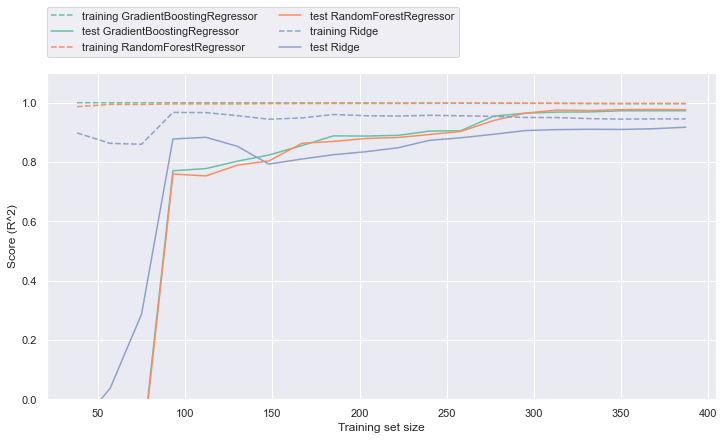

In [33]:
# Plot learning curve to compare the 2 best models
v = dic_variables.get("Same Means")
X = agriculture_df.loc[:, v]
y = agriculture_df[dependant_variable].values
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

plt.figure(figsize=(12, 6))
plot_learning_curve(GradientBoostingRegressor(), X, y)
plot_learning_curve(RandomForestRegressor(), X, y)
plot_learning_curve(Ridge(), X, y)
plt.legend(loc=(0, 1.05), ncol=2, fontsize=11)
plt.savefig("../visualizations/02_ml_learning_curve_best_models.png")